In [1]:
!pip install transformers

In [2]:
!pip install tensorflow==2.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 5.3 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 551.4 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 88.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 37.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting unins

In [3]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 75.1 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1


In [4]:
# Instalar dependencias en Colab
#!pip install tensorflow vit-keras openpyxl

# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MinMaxScaler
from transformers import ViTModel, ViTFeatureExtractor
from PIL import Image
import os


In [5]:
# Parámetros de imagen
rows, cols, channels = 224, 224, 3  # Redimensionar imágenes a cuadrado para ViT
image_size = 224  # Tamaño de imagen en ViT
output_feature = "biomasa"  # Columna objetivo
patch_size = 16  # Tamaño del parche (ViT)


In [6]:
# Ruta a los datos
data_path = '/kaggle/input/data-horas/Datos_horas.xlsx'  # Carga tu archivo Excel en Colab
image_dir = '/kaggle/input/fotos-horas/Datos_horas'  # Carpeta con imágenes de entrenamiento

# Cargar datos
data = pd.read_excel(data_path)
input_features = ['Irradiancia', 'NO3', 'TEMP', 'pH', 'CO2 Gas']  # Ajusta según tus columnas
target_feature = 'Biomasa'

In [7]:
# Escalar los datos
scaler = MinMaxScaler()
data[input_features] = scaler.fit_transform(data[input_features])
data[target_feature] = scaler.fit_transform(data[[target_feature]])

In [11]:
# Cargar el extractor de características para ViT
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB").resize((image_size, image_size))  # Redimensionar a (224, 224)
    
    # Convertir la imagen a un array NumPy
    img = np.array(img)  # Convertir a array NumPy
    
    # Verificar que la forma sea (224, 224, 3)
    if img.shape != (224, 224, 3):
        raise ValueError(f"Imagen con forma inesperada: {img.shape}")
    
    # Usar el feature extractor para preprocesar la imagen para ViT
    pixel_values = feature_extractor(images=img, return_tensors="np").pixel_values  # Forma: (1, 3, 224, 224)
    
    # Convertir de (1, 3, 224, 224) a (224, 224, 3)
    img_processed = np.transpose(pixel_values[0], (1, 2, 0))
    
    return img_processed

# Cargar imágenes y redimensionar para ViT
all_images = []
for day in range(1, 31):  # Suponiendo 30 días
    day_folder = os.path.join(image_dir, f'dia {day}')
    if not os.path.exists(day_folder):
        continue
    for img_name in sorted(os.listdir(day_folder)):
        img_path = os.path.join(day_folder, img_name)
        all_images.append(preprocess_image(img_path))

# Convertir la lista de imágenes a un array NumPy
all_images = np.array(all_images)  # Forma esperada: (num_images, 224, 224, 3)
print(f"Total de imágenes cargadas: {all_images.shape}")


Total de imágenes cargadas: (720, 224, 224, 3)


In [ ]:
# División de datos
img_train, img_test, y_train, y_test = train_test_split(all_images, data[target_feature].values, test_size=0.3, random_state=42)

# Cargar modelo preentrenado de ViT
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
# Construcción del modelo
inp = Input(shape=(image_size, image_size, 3))
x = Flatten()(inp)  # Simulación de salida de ViT para fine-tuning
x = Dense(32, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)

x = Dense(256, activation="relu")(x)
x = Dense(256, activation="tanh")(x)
output = Dense(1, activation="linear")(x) #linear

model_vit = Model(inputs=inp, outputs=output)
model_vit.compile(optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mae", "mse"])

# Entrenamiento
early_stop = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
history_vit = model_vit.fit(
    img_train, y_train,
    validation_data=(img_test, y_test),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predicción y métricas
y_pred = model_vit.predict(img_test).flatten()
metrics = {
    "R2": r2_score(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    
    "MAPE": mean_absolute_percentage_error(y_test, y_pred),
}

print(metrics)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/500
16/16 [==============================] - 2s 54ms/step - loss: 0.0802 - mae: 0.2207 - mse: 0.0802 - val_loss: 0.0102 - val_mae: 0.0871 - val_mse: 0.0102
Epoch 2/500
16/16 [==============================] - 1s 41ms/step - loss: 0.0099 - mae: 0.0798 - mse: 0.0099 - val_loss: 0.0035 - val_mae: 0.0448 - val_mse: 0.0035
Epoch 3/500
16/16 [==============================] - 1s 40ms/step - loss: 0.0048 - mae: 0.0523 - mse: 0.0048 - val_loss: 0.0026 - val_mae: 0.0380 - val_mse: 0.0026
Epoch 4/500
16/16 [==============================] - 1s 42ms/step - loss: 0.0035 - mae: 0.0436 - mse: 0.0035 - val_loss: 0.0025 - val_mae: 0.0379 - val_mse: 0.0025
Epoch 5/500
16/16 [==============================] - 1s 31ms/step - loss: 0.0029 - mae: 0.0393 - mse: 0.0029 - val_loss: 0.0029 - val_mae: 0.0400 - val_mse: 0.0029
Epoch 6/500
16/16 [==============================] - 1s 34ms/step - loss: 0.0034 - mae: 0.0430 - mse: 0.0034 - val_loss: 0.0024 - val_mae: 0.0365 - val_mse: 0.0024
Epoch 7/500
16/1

In [19]:
# División de datos
img_train, img_test, y_train, y_test = train_test_split(all_images, data[target_feature].values, test_size=0.3, random_state=42)

# Construcción del modelo Vision Transformer
vit_model = vit.vit_b16(
    image_size=image_size,
    pretrained=True,
    include_top=False,
    pretrained_top=False,
)

inp = Input(shape=(rows, cols, channels))
x = vit_model(inp)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
output = Dense(1, activation="linear")(x)

model_vit = Model(inputs=inp, outputs=output)
model_vit.compile(optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mae", "mse"])

# Entrenamiento
early_stop = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
history_vit = model_vit.fit(
    img_train, y_train,
    validation_data=(img_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predicción y métricas
y_pred = model_vit.predict(img_test).flatten()
metrics = {
    "R2": r2_score(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred),
}




NameError: name 'vit' is not defined

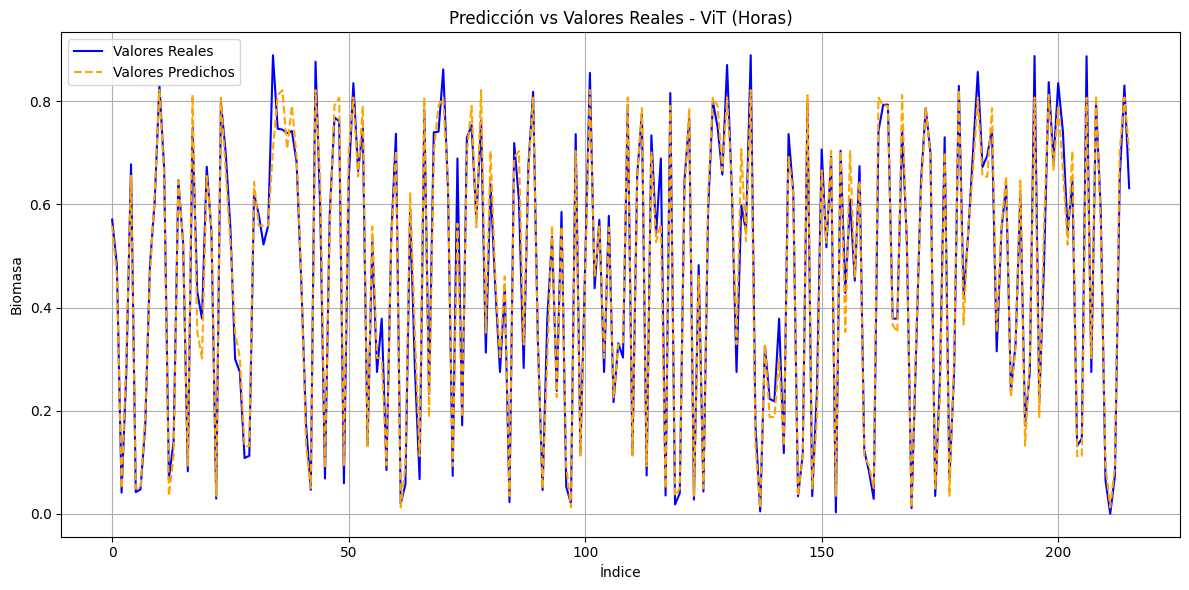

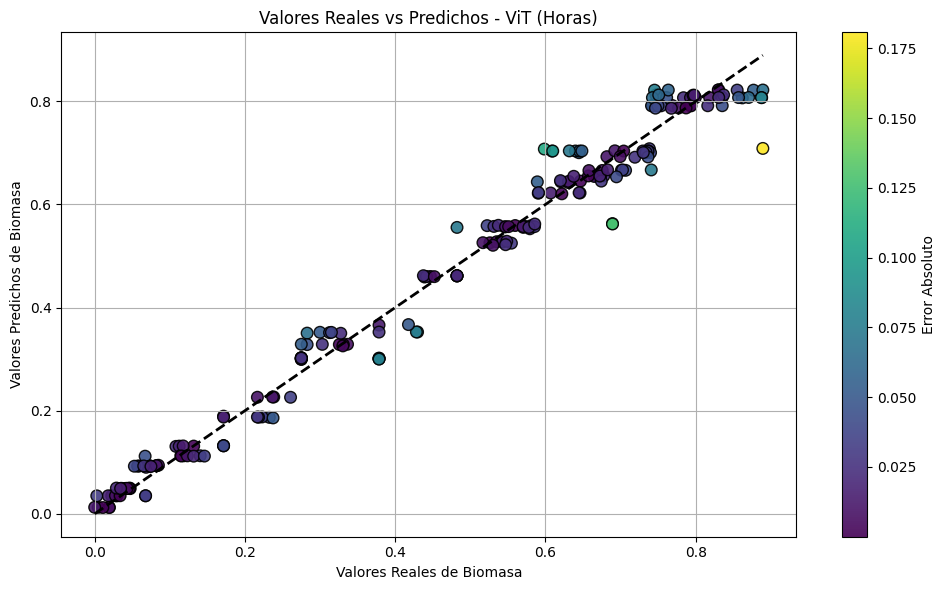

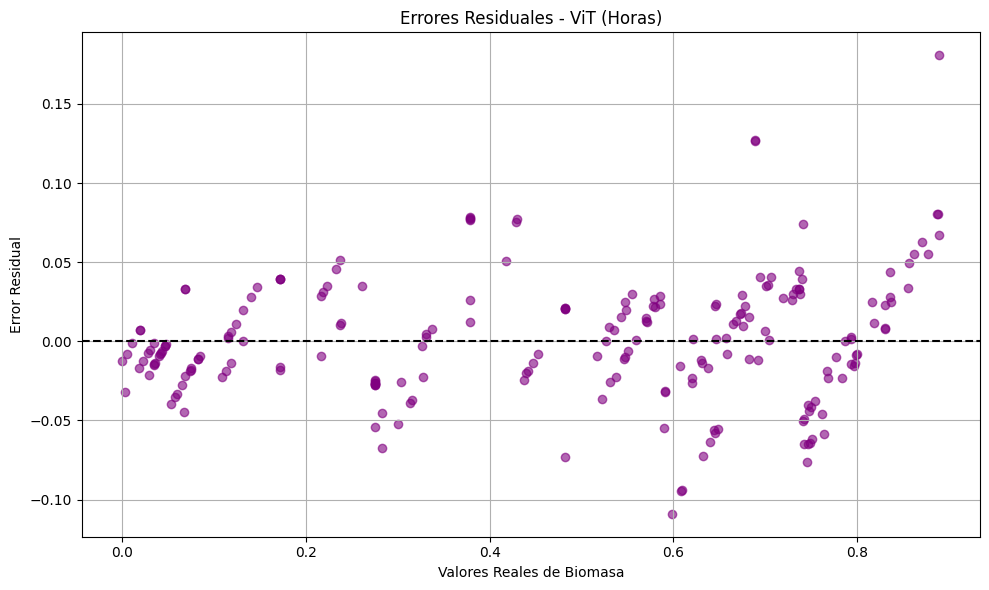

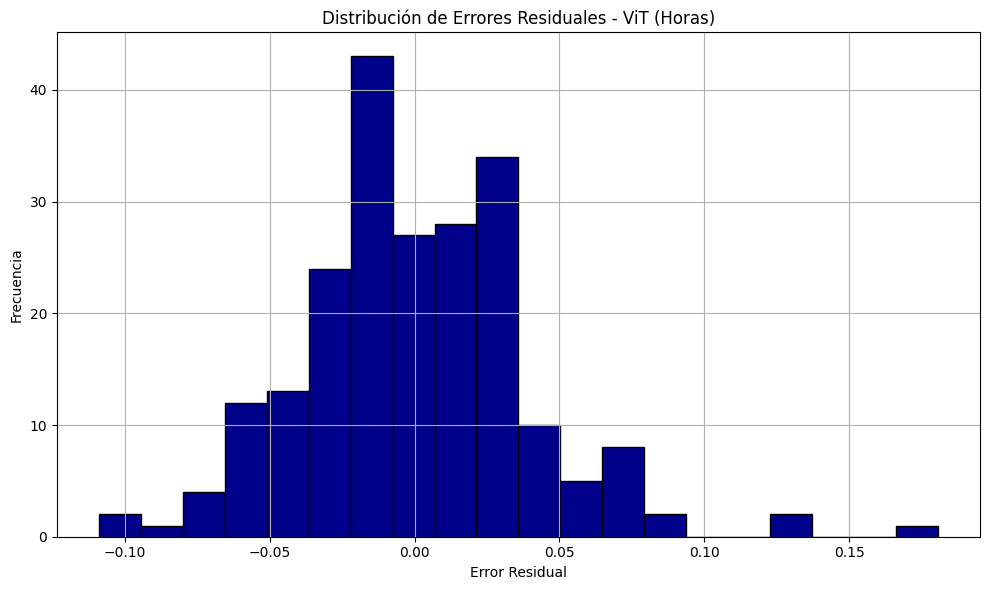

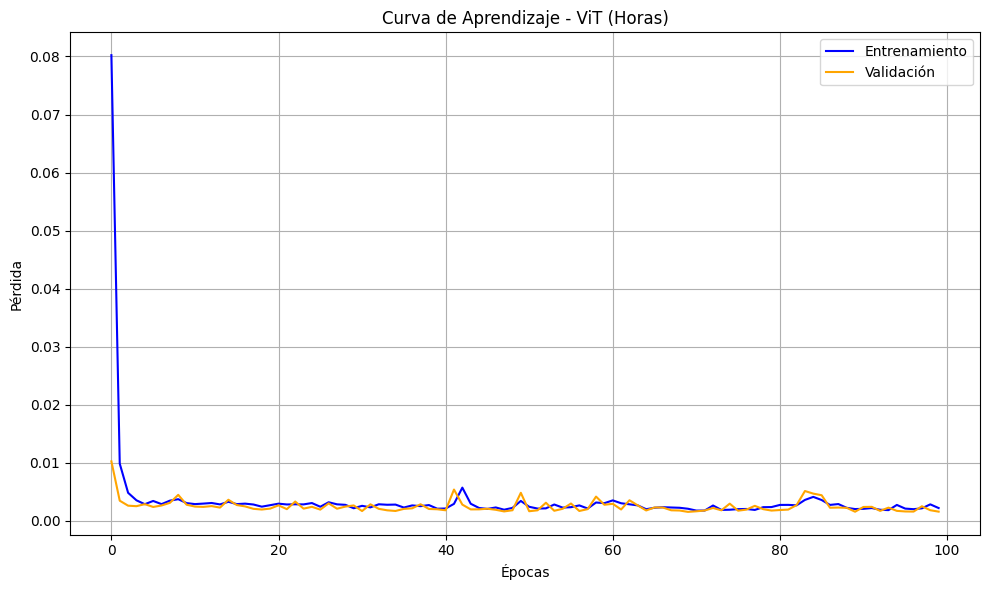

In [13]:

# Visualización de resultados
# Gráfico 1: Predicciones vs Reales
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Valores Reales', color='blue')
plt.plot(y_pred, label='Valores Predichos', color='orange', linestyle='--')
plt.title('Predicción vs Valores Reales - ViT (Horas)')
plt.xlabel('Índice')
plt.ylabel('Biomasa')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Gráfico 2: Dispersión de Predicciones vs Reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c=np.abs(y_test - y_pred), cmap='viridis', s=70, alpha=0.9, edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Valores Reales vs Predichos - ViT (Horas)')
plt.xlabel('Valores Reales de Biomasa')
plt.ylabel('Valores Predichos de Biomasa')
plt.colorbar(label='Error Absoluto')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: Errores Residuales
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6, color="purple")
plt.axhline(0, linestyle='--', color='black')
plt.title('Errores Residuales - ViT (Horas)')
plt.xlabel('Valores Reales de Biomasa')
plt.ylabel('Error Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 4: Histograma de Errores
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color="darkblue", edgecolor='black')
plt.title('Distribución de Errores Residuales - ViT (Horas)')
plt.xlabel('Error Residual')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 5: Curva de Aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(history_vit.history['loss'], label='Entrenamiento', color='blue')
plt.plot(history_vit.history['val_loss'], label='Validación', color='orange')
plt.title('Curva de Aprendizaje - ViT (Horas)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()